# Optimizing the Intractable with Variational Inference


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/florpi/summer_school_generative/blob/main/1_variational_inference_with_jax.ipynb)


In [ ]:
# We'll start by installing some packages while you read the text below.
!pip install numpy jax jax-cosmo numpyro flax einops optax matplotlib 


In this notebook we will go through an example from cosmology to demonstrate how variational inference works and to showcase how efficient it can be. The goal of this notebook is to understand how we can turn an inference problem into an optimization one, particularly in high-dimensional spaces.  This notebook makes extensive use of the [jax](https://jax.readthedocs.io/en/latest/) library, a versatile tool that fuses an intuitive numpy-style API with the innovative capabilities of autodiff and GPU acceleration. We will introduce the ways in which jax can empower scientific computations as we move along.

Code that needs to be filled in will be marked by #TODOs. There will also be some questions to check your understanding within the notebook marked with 🤔 


The notebook is structured as follows:

## Table of Contents
1. [Describing the problem: What is the Universe made of?](#what-is-the-universe-made-of)
2. [Maximum likelihood estimate with gradient ascent](#mle-with-gradient-ascent)
3. [Estimating the posterior distribution naively](#estimating-posteriors-naively)
4. [Variational Inference](#Variational-Inference)

In [2]:
import jax.numpy as np
import jax
from jax import jit, grad, vmap
# We will use jax_cosmo library to define some differentiable cosmological functions
from jax_cosmo.power import nonlinear_matter_power
from jax_cosmo import Cosmology

import optax
import numpyro.distributions as dist
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


##  What is the Universe made of?

Cosmological parameters are the key numerical quantities that define our universe's properties, such as the density of dark matter, the expansion rate of the universe (Hubble constant), and the geometry of the universe. We useobservations of the 3D distribution of galaxies or of the temperature fluctuations in the Cosmic Microwave Background (CMB), to analyse the patterns and structures that emerged from the early universe and have evolved over billions of years. 

In particular, the power spectrum of the galaxy distribution or of the CMB is used to summarize the data in such a way that we can extract the relevant information to figure out what the universe is made of. The power spectrum is a statistical description of how spatial fluctuations in a field (such as density or temperature) are distributed across different scales. Think of it as a way to quantify the "clumpiness" of the universe at various scales. In fact, if the field can be represented by a Gaussian random field, its power spectrum contains as much information as that of the entire field. Interestingly, we believe that this is the case for the matter fluctuations in the early Universe. This is however corrupted by gravitational evolution, and therefore the late Universe's matter fluctuations cannot be losslessly summarised in its power spectrum. How to do lossless inference with observations of the late Universe is an active field of research today where probabilistic machine learning is having a big impact.

Here, we will show how we can infer the mapping between cosmological parameters and the power spectrum to constrain the universe's properties.



**TL;DR:** We want to fit a set of parameters (cosmological parameters) to some observed data (the power spectrum)


In [3]:
# Let's start by generating some power spectra using jax cosmo and some cosmological parameters

Omega_c = 0.3 # dark matter energy density
Omega_b = 0.05 # baryon energy density
h=0.7 # Hubble constant
n_s=0.96 # spectral index of the primordial power spectrum
sigma8=0.8 # normalization of the power spectrum at 8 Mpc/h 
Omega_k=0. # curvature energy density
w0=-1. # dark energy equation of state parameter
wa=0. # dark energy equation of state parameter
cosmo = Cosmology(
    Omega_c=Omega_c, 
    Omega_b=Omega_b,
    h=h,
    sigma8 = sigma8,
    n_s=n_s,
    Omega_k=Omega_k, 
    w0=w0, 
    wa=wa,
)

In [4]:
# we will generate a power spectrum for that cosmology, as a function of wavenumber k
k = np.logspace(-3,1)
pk_obs = nonlinear_matter_power(cosmo, k/cosmo.h, a=1.0)/cosmo.h**3



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Text(0, 0.5, 'P(k) $(\\mathrm{Mpc}/h)^3$')

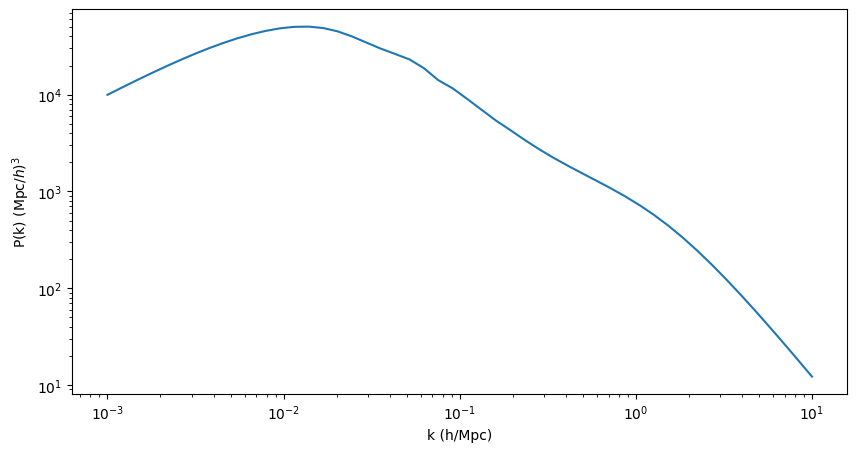

In [5]:
plt.figure(figsize=[10,5])
plt.loglog(k, pk_obs, )
plt.xlabel('k (h/Mpc)')
plt.ylabel('P(k) $(\mathrm{Mpc}/h)^3$')

Now we can add some errorbars to this plot by computing the expected covariance matrix using perturbation theory (dont worry about the derivation, what matters is that we can use assumptions such as the Gaussian Random Field to estimate the covariance of the power spectrum)

In [6]:
V = 5e2 # Example observed volume

# Compute the diagonal elements of the covariance matrix
covariance_diagonal = 2 / V * pk_obs**2
# In linear perturbation theory the covariance matrix is diagonal
covariance_matrix = np.diag(covariance_diagonal)

inverse_covariance_matrix = np.linalg.inv(covariance_matrix)


Text(0, 0.5, 'P(k) $(\\mathrm{Mpc}/h)^3$')

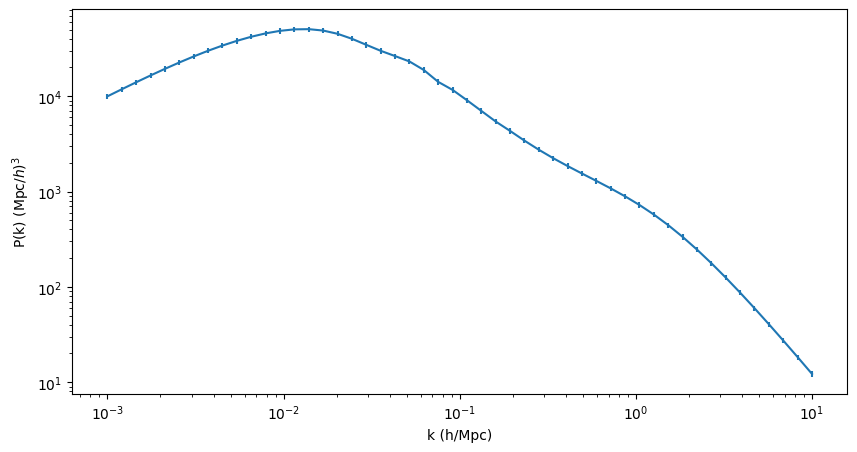

In [7]:
error_bars = np.sqrt(np.diag(covariance_matrix))

# Plot the power spectrum with error bars
plt.figure(figsize=[10,5])
plt.errorbar(k, pk_obs, yerr=error_bars, label='P(k)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (h/Mpc)')
plt.ylabel('P(k) $(\mathrm{Mpc}/h)^3$')

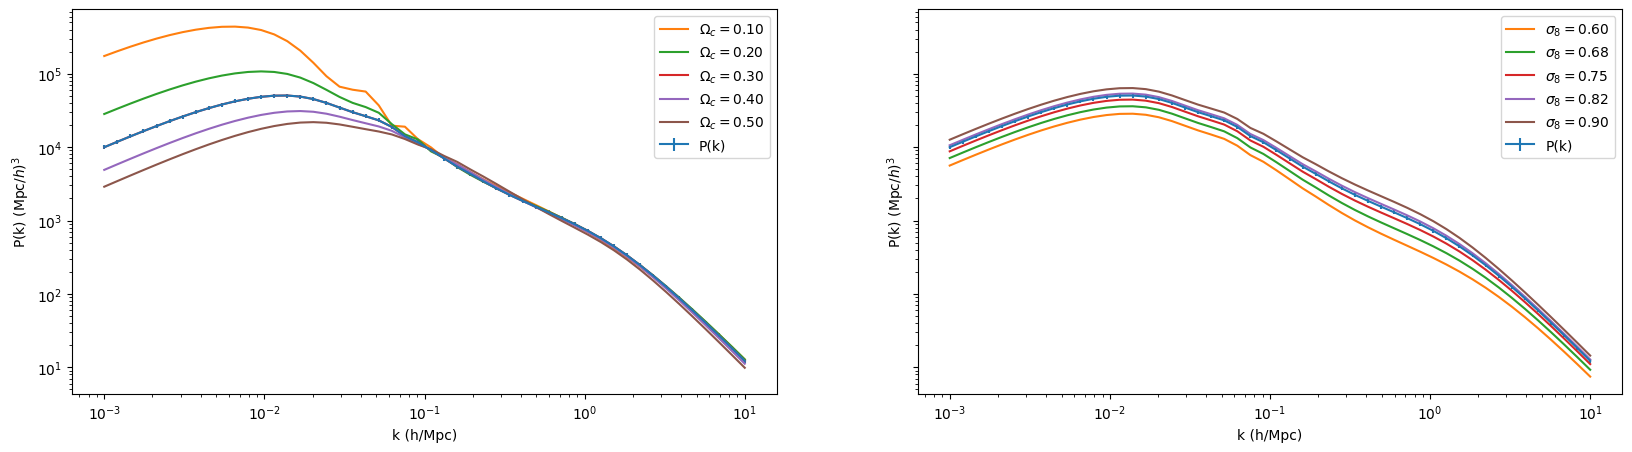

In [8]:
# Let's show a couple of other power spectrum when varying two of the cosmological parameters: O_cdm and sigma8
@jit
def get_power_spectrum(Omega_c, sigma8):
    cosmo = Cosmology(
        Omega_c=Omega_c, 
        Omega_b=Omega_b,
        h=h,
        sigma8 = sigma8,
        n_s=n_s,
        Omega_k=Omega_k, 
        w0=w0, 
        wa=wa,
    )
    return nonlinear_matter_power(cosmo, k/cosmo.h, a=1.0)/cosmo.h**3

omega_c_varying = np.linspace(0.1, 0.5, 5)

fig, ax = plt.subplots(figsize=[20,5], ncols=2, sharey=True, sharex=True)

ax[0].errorbar(k, pk_obs, yerr=error_bars, label='P(k)')
ax[1].errorbar(k, pk_obs, yerr=error_bars, label='P(k)')

for oc in omega_c_varying:
    ax[0].loglog(k, get_power_spectrum(oc,  sigma8), label=f'$\Omega_c={oc:.2f}$')
ax[0].set_xlabel('k (h/Mpc)')
ax[0].set_ylabel('P(k) $(\mathrm{Mpc}/h)^3$')
ax[0].legend()

sigma8_varying = np.linspace(0.6, 0.9, 5)
for s8 in sigma8_varying:
    ax[1].loglog(k, get_power_spectrum(Omega_c,  s8), label=f'$\sigma_8={s8:.2f}$')
ax[1].set_xlabel('k (h/Mpc)')
ax[1].set_ylabel('P(k) $(\mathrm{Mpc}/h)^3$')
ax[1].legend()



Our goal today will be to find the values of the cosmological parameters that best fit the observed power spectrum

## MLE with gradient ascent

In this section we will show how to define the likelihood of the power spectrum given the cosmological parameters, $p(x|\theta)$, where $x$ is the observed power spectrum and $\theta$ are the cosmological parameters. Here, we will focus on fitting $\Omega_{cdm}$ and $\sigma_8$. We will show how we can find an estimate of the maximum likelihood parameters by simply following the direction of maximum likelihood variation through gradient ascent.

In [7]:
# to compile a function with jax, we can use the jit decorator (it will run faster!)
@jit
def log_likelihood(theta: np.array, pk_obs: np.array,)->float:
    """ compute the log likelihood of the data given the parameters theta

    Args:
        theta (np.array): cosmological parameters 
        pk_obs (np.array): observed power spectrum 

    Returns:
        float: log likelihood 
    """
    Oc, s8 = theta
    cosmo = Cosmology(
        Omega_c=Oc, 
        Omega_b=Omega_b,
        h=h,
        sigma8 = s8,
        n_s=n_s,
        Omega_k=Omega_k, 
        w0=w0, 
        wa=wa,
    )
    pk_mean = nonlinear_matter_power(cosmo, k/cosmo.h, a=1.0)/cosmo.h**3
    # 🤔 Some terms of the log likelihood can be ignored here, why can we do that?
    return #TODO: Define the log likelihood as a Gaussian with mean pk_mean and covariance matrix covariance_matrix

In [8]:
%%timeit

# Although not extreme in this case, likelihood evaluations can be very expensive. 
# Think for instance of needing to run an N-body simulation to evaluate your likelihood.

log_likelihood(np.array([0.3, 0.8]), pk_obs,)


308 µs ± 54.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
log_likelihood(np.array([0.3, 0.8]), pk_obs,)

Array(-3.6499364e-09, dtype=float32)

In [10]:
log_likelihood([0.25, 0.7], pk_obs,)

Array(-332.25714, dtype=float32)

In [11]:
# as stated above, jax can automatically compute the gradient of a function
grad_log_likelihood = grad(log_likelihood)

In [12]:

print(f'Likelihood gradient = {grad_log_likelihood([0.3,0.8], pk_obs,)}')

Likelihood gradient = [Array(-0.01297368, dtype=float32, weak_type=True), Array(0.02890359, dtype=float32, weak_type=True)]


In [13]:
# we can also call jit like this
# next time we call the function it'll run faster!
grad_log_likelihood = jit(grad(log_likelihood))

In [ ]:
# make sure that we can evaluate it
print(grad_log_likelihood(np.array([0.2,0.7]), pk_obs))

In [14]:
# Let's now follow the gradient of the log likelihood to find the maximum likelihood parameters

n_steps = 100
learning_rate = 1e-6

# start from a random point in parameter space
theta = np.array([0.2,0.7])

pbar = tqdm(range(n_steps))
for _ in pbar:
    theta += #TODO: update theta using the gradient of the log likelihood
    pbar.set_postfix({'loglike': log_likelihood(theta, pk_obs,)})


  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
print(fr"The MLE estimates are $\Omega_{{cdm}}$ = {theta[0]}, $\sigma_8$ = {theta[1]}")


The MLE estimates are $\Omega_{cdm}$ = 0.2996431887149811, $\sigma_8$ = 0.7992324829101562


🤔 Now you can try to visualize the path followed by the gradient descent algorithm in parameter space

## Estimating posteriors naively

Although now we now the maximum likelihood estimate, we would like to estimate the uncertainty on the estimated parameters. This is currently very important for cosmology, since over the past few years we found inconsistencies in the estimated cosmological parameters when comparing the early and the late Universe. You can read more about these so called tensions [here](https://arxiv.org/abs/2203.06142). When the parameter space we are interested in is of low dimensionality, like only two cosmological parameters, we can directly apply Bayes' theorem on a grid to obtain the posterior distribution as follows

$p(\theta|x) = \frac{p(x|\theta) p(\theta)}{p(x)}$

where $p(\theta|x)$ is the posterior distribution we are interested in, $p(x|\theta)$ is the likelihood defined above, $p(\theta)$ is the prior knowledge on the parameters of interest, and $p(x)$ is the so-called evidence, defined as $p(x) = \int d \theta p(x|\theta) p(\theta)$. The challenge to obtain posteriors is to compute the evidence in a large dimensional paratermer space. In this subsection, we will ignore the evidence and just estimate the unnormalized posterior on a grid to get our first estimate.

In [16]:
def log_prior(theta: np.array)->float:
    """ compute the log prior of the parameters theta. Normally, it is defined as either 
    the posterior from a previous analysis (such as the CMB) or a flat prior, 
    here we will have some Gaussian priors on the parameters

    Args:
        theta (np.array): cosmological parameters 

    Returns:
        float: log prior     
    """
    Oc, s8 = theta.T
    return dist.Normal(0.2, 0.1).log_prob(Oc) + dist.Normal(0.7,0.1).log_prob(s8)


In [17]:
def get_unnormalized_posterior(theta: np.array, pk_obs: np.array)->float:
    """ compute the unnormalized posterior of the parameters theta (Bayes theorem)

    Args:
        theta (np.array): parameters to evaluate the posterior at 
        pk_obs (np.array): observed power spectrum 

    Returns:
        float: unnormalized posterior 
    """
    return log_prior(theta) + log_likelihood(theta, pk_obs)


In [18]:
# generate a grid fo cosmological parameters
Omega_cdm_grid, sigma8_grid = np.mgrid[0.25:0.35:100j, 0.75:0.85:100j]
cosmo_grid = np.stack((Omega_cdm_grid, sigma8_grid), axis=0)

print(cosmo_grid.shape)


(2, 100, 100)


In [19]:
# Now we want to call the unnormalized posterior function for each pair of parameters in the grid
# We can do that with jax.vmap, which will automatically vectorize the function
log_post_vmap = jit(vmap(get_unnormalized_posterior, in_axes=(0,None,)))

log_post_grid = log_post_vmap(cosmo_grid.reshape(-1, 100* 100).T, pk_obs)

In [20]:
post_grid = np.exp(log_post_grid.reshape(100,  100)) / np.sum(np.exp(log_post_grid))

/var/folders/7y/yr347mzn06zc5zl3p_qxq4v40000gn/T/ipykernel_46232/1245227405.py:1: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(np.unique(Omega_cdm_grid), np.unique(sigma8_grid), np.log(post_grid),origin='lower', aspect='auto', cmap='Blues',)


Text(0, 0.5, '$\\sigma_8$')

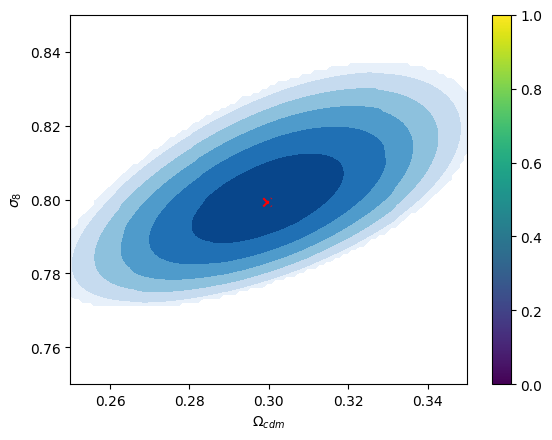

In [21]:
plt.contourf(np.unique(Omega_cdm_grid), np.unique(sigma8_grid), np.log(post_grid),origin='lower', aspect='auto', cmap='Blues',) 
plt.scatter(theta[0], theta[1], marker='x', color='red', label='MLE', linestyle='--')
plt.colorbar()

plt.xlabel(r"$\Omega_{cdm}$")
plt.ylabel(r"$\sigma_8$")

🤔 But, how does this grid method scale with the number of parameters? How many likelihood evaluations would we need?

## Variational Inference

Although there are much smarter ways to sample a posterior distribution than a naive grid search (see  [numpyro](https://num.pyro.ai/en/stable/mcmc.html), for MCMC and HMC implementations), we will focus here on approximate methods that scale extremely well to large dimensional spaces. In particular, we will show in the next notebook how variational inference is used for generative models.

Going back to our problem, we want to infer the posterior distribution $p(\theta | x)$ of some parameters $\theta$ given some observed data $x$. By Bayes' theorem, we have:

$p(\theta | X) = \frac{p(X | \theta)p(\theta)}{p(X)}$ 

where we cant compute $ p(X) = \int p(X | \theta) p(\theta) d\theta $ due to $\theta$ being high dimensional

### Variational Family

We'll introduce a variational family $q_\phi(\theta | x)$, which will be a tractable distribution over $\theta$ parameterized by some parameters $\phi$. We want to make this distribution as close as possible to the true posterior by varying the parameters $\phi$.

### Objective Function

We will use the Kullback-Leibler divergence to measure the similarity between the variational posterior and the true posterior

$D_{\mathrm{KL}}(q_\phi(\theta) || p(\theta | x))$

the problem is, we don't know the true posterior $p(\theta|x)$, since this is exactly what we want to learn.

Using Bayes' theorem however, we can rewrite the KL divergence:

$$
\begin{align*}
 D_{\mathrm{KL}}(q_\phi(\theta) || p(\theta | x)) &= \langle \log q_\phi(\theta)- \log p(\theta | X) \rangle_{q_\phi(\theta)} \\
&= \langle \log q_\phi(\theta) - \log (p(x | \theta) p(\theta)) + \log p(x) \rangle_{q_\phi(\theta)} \\
&=  \langle \log q_\phi(\theta)  - \log p(x | \theta) - \log p(\theta)  \rangle_{q_\phi(\theta)}  + \log p(X)
\end{align*}
$$

### Evidence Lower Bound (ELBO)

The term $\log p(x)$ does not depend on the variational parameters $\phi$, so we can define a new objective, called the Evidence Lower Bound (ELBO):

$\text{ELBO}(\phi) = \langle \log p(x | \theta) + \log p(\theta) - \log q_\phi(\theta ) \rangle_{q_\phi(\theta)}  $

Here, we will estimate the ELBO via monte carlo by first drawing samples from the variational distribution $q$. Given  $S$ samples $\theta^{(s)} \sim q_\phi(\theta)$, the MC estimate of the ELBO can be expressed as:

$\hat{\text{ELBO}}(\phi) = \frac{1}{S} \sum_{s=1}^{S} \left( \log p(x | \theta^{(s)}) + \log p(\theta^{(s)}) - \log q_\phi(\theta^{(s)}) \right)$

Here:
- $\theta^{(s)}$ represents the $s$-th sample from the variational distribution  $q_\phi(\theta)$ .
-  $S$ is the number of samples used in the Monte Carlo estimation.


Now, we have:

$ D_{\mathrm{KL}}(q_\phi(\theta) || p(\theta | x))  = -\text{ELBO}(\phi) + \log p(x) $ 

Since $\log p(X)$ is fixed, minimizing the KL divergence is equivalent to maximizing the ELBO. Moreover, since we are training the model to reduce the KL divergence between the variational posterior and the true posterior, and since the KL divergence is positive, the ELBO is a lower bound to the evidence. If the variational posterior approximates the true posterior well, the ELBO will approximately give us the evidence. 

### Optimization

We can then use gradient-based optimization techniques to find the optimal $\phi$, and thus the approximation $q_\phi(\theta)$ to our intractable posterior.

Let's see how we can find the posterior of the cosmological parameters in our previous example using variational inference.



In [22]:
# we are going to need a vectorized version of the log likelihood function
log_likelihood_vmap = vmap(log_likelihood, in_axes=(0,None,))

def evidence_lower_bound(q: "dist.Distribution", theta: np.array, pk_obs: np.array)->float:
  """ compute the evidence lower bound (ELBO) of the parameters theta

  Args:
      q (dist.Distribution): variational distribution 
      theta (np.array): cosmological parameters (sampled from the variational distribution)
      pk_obs (np.array): observed power spectrum 

  Returns:
      float: evidence lower bound 
  """
  return #TODO: compute the ELBO given samples from the variational distribution and the observed power spectrum

In [23]:
# For the variational distribution, we will use two independent Gaussian distributions,
# but we will truncate both such that they only have support on positive values 
# Note that we have seen in our naive exploration that the parameters are indeed correlated
# so this is not a great approximation, but it will do for now
normal = dist.TruncatedNormal(np.zeros(2), np.ones(2), low=0.)
diag_normal = dist.Independent(normal, 1)
# The mean and variance of the variational distribution will be the parameters we will optimize

In [24]:
# make sure that we can evaluate the ELBO, given some samples from the variational distribution
key = jax.random.PRNGKey(32)
samples = diag_normal.sample(key=key, sample_shape=(20,))

print(evidence_lower_bound(diag_normal, samples, pk_obs))

Array(-0.71658266, dtype=float32)

In [25]:
from typing import Dict

def loss(params: Dict, key: "jax.random.PRNGKey", n_samples: int = 256,)->float:
  """ Estimate the elbo loss for a given set of parameters, using the Monte Carlo estimation

  Args:
      params (Dict): parameters that define the variational distribution 
      key (jax.random.PRNGKey): random key used to generate samples from the variational distribution
      n_samples (int, optional): number of monter carlo samples used to estimate elbo. Defaults to 256.

  Returns:
      float: mcmc estimate of the elbo loss 
  """
  # To estimate the ELBO, we will sample a batch from variational distribution q
  # The parameters we are optimizing are the mean and variance of the variational distribution
  normal = dist.TruncatedNormal(
    params['mean'], 
    params['variance']**2,
    low=0., # Make sure that the variational distribution q only has support on positive values
  )
  q = dist.Independent(normal, 1) # Create a multivariate normal with diagonal covariance matrix
  # Sample from the variational distribution
  theta_samples = #TODO: Sample from the variational distribution q 
  # Compute Monte Carlo estimate of the evidence lower bound.
  elbo_loss = #TODO: Compute the ELBO loss using the samples from the variational distribution
  # Turn elbo into a loss.
  return -elbo_loss

In [26]:
# Initialise parameters 
params = {
    'mean': np.array([0.2,0.7]),
    'variance': np.array([0.1,0.1]),
}
# Get a function that computes the loss and its gradient
loss_val_grad = jit(jax.value_and_grad(loss))
# Initialise the optimizer with the parameters we want to optimize
optimiser = optax.adam(learning_rate=1.e-3)
opt_state = optimiser.init(params)

In [27]:
key = jax.random.PRNGKey(42)
# Check that we can estimate the elbo, and make sure it has low variance
print('elbo = ', loss(params, key))
key = jax.random.PRNGKey(32)
print('elbo = ', loss(params, key))

# 🤔  What parameter should you change to reduce the variance of the elbo estimate if it is high?

elbo =  2221.7036
elbo =  2341.9834


In [28]:
n_iter = 500 
keys = jax.random.split(jax.random.PRNGKey(42), num=n_iter)

elbos = []

for i, key in enumerate(keys):
  elbo, grads = loss_val_grad(params, key)
  updates, opt_state = optimiser.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  elbos.append(elbo)

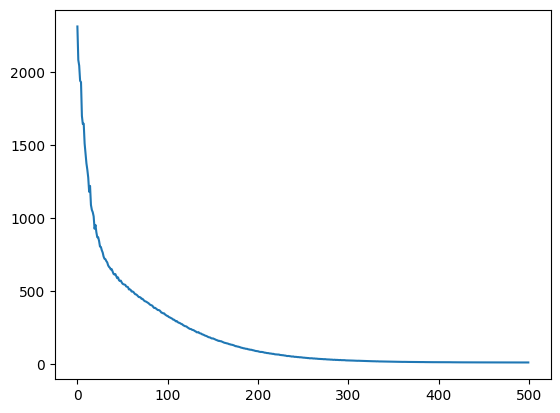

In [29]:
# see how the elbo changes as it is optimized
plt.plot(elbos)

/var/folders/7y/yr347mzn06zc5zl3p_qxq4v40000gn/T/ipykernel_46232/1578449913.py:11: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(np.unique(Omega_cdm_grid), np.unique(sigma8_grid), log_pdf_values,origin='lower', aspect='auto', cmap='Blues',)


Text(0, 0.5, '$\\sigma_8$')

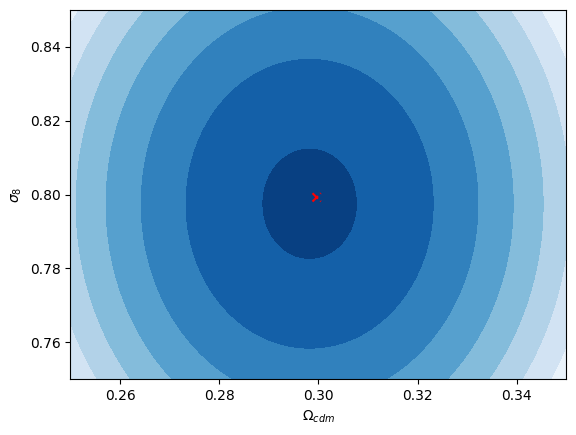

In [30]:
# Evaluate the PDF at the points on the grid
normal = dist.TruncatedNormal(
    params['mean'], 
    params['variance']**2,
    low=0., 
)
log_pdf_values = dist.Independent(normal, 1).log_prob(cosmo_grid.astype(np.float32).swapaxes(0,-1)) #


# Plot the posterior 
plt.contourf(np.unique(Omega_cdm_grid), np.unique(sigma8_grid), log_pdf_values,origin='lower', aspect='auto', cmap='Blues',) 
plt.scatter(theta[0], theta[1], marker='x', color='red', label='True', linestyle='--')
plt.xlabel(r'$\Omega_{cdm}$')
plt.ylabel('$\sigma_8$')

In [31]:
# 🤔  How would you include parameter correlations in the variational family? 
# See in the naive posterior they were correlated.

# 🤔  Can you generalise this code to fit all cosmological parameters at once? 
# How does it compare to the naive grid evaluation in terms of number of likelihood evaluations?

## Summary 

In this notebook, we have learned how to write down the ELBO to find an approximation of the true posterior distribution in cases where the parameter space might be  high dimensional. In essence, we have turned an intractable sampling problem into an optimization one. 

Here are some examples from physics related papers that used Variational Inference to do some cool research:

* [Variational methods for simulation-based inference](https://arxiv.org/abs/2203.04176)
* [To Sample or Not To Sample: Retrieving Exoplanetary Spectra with Variational Inference and Normalising Flows](https://arxiv.org/abs/2205.07037)
* [Semi-parametric γ-ray modeling with Gaussian processes and variational inference](https://arxiv.org/abs/2010.10450)
* [Stochastic Gradient Bayesian Optimal Experimental Designs for Simulation-based Inference](https://arxiv.org/abs/2306.15731)




